<a href="https://colab.research.google.com/github/mkwatson/A-Cake/blob/master/StonksPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install fastai pandas numpy matplotlib
!pip install pyts timm

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
from fastai.tabular.all import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls "/content/drive/My Drive/Stonks Predictor/"

model.pkl  stock_data  StonksPredictor.ipynb


In [6]:
def read_stock_data(ticker):
    prices_df = pd.read_csv(f'/content/drive/My Drive/Stonks Predictor/stock_data/daily_prices/{ticker}_closing_prices.csv', parse_dates=['Date'])
    earnings_df = pd.read_csv(f'/content/drive/My Drive/Stonks Predictor/stock_data/earnings/{ticker}_earnings_dates.csv', parse_dates=['Earnings Date'])
    return prices_df, earnings_df

# Test with AAPL
aapl_prices, aapl_earnings = read_stock_data('AAPL')

print("AAPL Prices:")
print(aapl_prices.head())
print("\nAAPL Earnings:")
print(aapl_earnings.head())

AAPL Prices:
                        Date      Close
0  2019-07-29 00:00:00-04:00  50.590385
1  2019-07-30 00:00:00-04:00  50.373245
2  2019-07-31 00:00:00-04:00  51.401077
3  2019-08-01 00:00:00-04:00  50.288799
4  2019-08-02 00:00:00-04:00  49.224773

AAPL Earnings:
               Earnings Date  EPS Estimate  Reported EPS  Surprise(%)
0  2024-05-02 16:00:00-04:00          1.50          1.53       0.0197
1  2024-02-01 16:00:00-05:00          2.10          2.18       0.0390
2  2023-11-02 16:00:00-04:00          1.39          1.46       0.0492
3  2023-08-03 16:00:00-04:00          1.19          1.26       0.0549
4  2023-05-04 16:00:00-04:00          1.43          1.52       0.0603


In [7]:
import os

def get_all_tickers():
    price_files = os.listdir('/content/drive/My Drive/Stonks Predictor/stock_data/daily_prices')
    return [file.split('_')[0] for file in price_files if file.endswith('_closing_prices.csv')]

tickers = get_all_tickers()
print(f"Found {len(tickers)} stocks")

Found 112 stocks


In [8]:
def prepare_stock_data(prices_df, earnings_df, lookback_days=60):
    data = []
    for _, earnings_row in earnings_df.iterrows():
        earnings_date = earnings_row['Earnings Date']

        try:
            earnings_index = prices_df[prices_df['Date'] <= earnings_date].index[-1]
        except IndexError:
            continue

        if earnings_index < lookback_days:
            continue

        lookback_data = prices_df.loc[earnings_index-lookback_days+1:earnings_index, 'Close'].values

        if len(lookback_data) < lookback_days:
            continue

        # Check for NaN values
        if np.isnan(lookback_data).any():
            continue

        lookback_data = (lookback_data - lookback_data.mean()) / lookback_data.std()

        try:
            next_day_close = prices_df.loc[earnings_index+1, 'Close']
        except KeyError:
            continue

        price_direction = 1 if next_day_close > prices_df.loc[earnings_index, 'Close'] else 0

        data.append((*lookback_data, price_direction))

    columns = [f'day_{i}' for i in range(lookback_days)] + ['target']
    df = pd.DataFrame(data, columns=columns)
    print(f"Prepared data shape: {df.shape}")
    return df

# Prepare AAPL data
aapl_prepared = prepare_stock_data(aapl_prices, aapl_earnings)

print("Prepared AAPL data:")
print(aapl_prepared.head())
print(f"Shape: {aapl_prepared.shape}")

Prepared data shape: (8, 61)
Prepared AAPL data:
      day_0     day_1     day_2     day_3     day_4     day_5     day_6  \
0  2.251649  2.083995  2.202581  1.940765  1.615807  1.478739  1.434078   
1 -2.283301 -1.738060 -1.512811 -1.613855 -0.722200 -1.059471 -0.502972   
2  0.225071  0.237930  0.595893  0.165049 -0.023577 -0.574458 -0.469420   
3 -1.633344 -1.409934 -1.386221 -1.503705 -1.566198 -1.566198 -1.488706   
4 -0.888902 -1.035690 -0.983886 -0.586258 -0.677264 -0.379046 -0.605859   

      day_7     day_8     day_9  ...    day_51    day_52    day_53    day_54  \
0  1.195364  1.079858  1.196907  ... -1.341154 -1.177905 -0.851406 -0.717419   
1 -0.382820 -0.024464 -0.028682  ...  0.856651  1.128579  0.985236  0.915678   
2 -0.180055  0.117890  0.951709  ... -0.788804 -0.694491 -1.196065 -2.098481   
3 -1.193749 -1.180003 -1.299987  ...  1.018430  1.127162  1.237148  1.077171   
4 -0.768270 -1.338106 -1.277904  ...  1.021042  0.802627  0.801227  1.452266   

     day_55    day_

In [9]:
def prepare_all_stock_data(tickers, lookback_days=60):
    all_data = []
    for ticker in tickers:
        prices_df, earnings_df = read_stock_data(ticker)
        stock_data = prepare_stock_data(prices_df, earnings_df, lookback_days)
        stock_data['ticker'] = ticker
        all_data.append(stock_data)

    combined_data = pd.concat(all_data, ignore_index=True)
    print(f"Combined data shape: {combined_data.shape}")
    return combined_data

combined_data = prepare_all_stock_data(tickers)

print("Combined data sample:")
print(combined_data.head())
print(f"Shape: {combined_data.shape}")

Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared data shape: (11, 61)
Prepared data shape: (2, 61)
Prepared data shape: (8, 61)
Prepared data shape: (12, 61)
Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared data shape: (11, 61)
Prepared data shape: (0, 61)
Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared data shape: (0, 61)
Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared data shape: (7, 61)
Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared data shape: (0, 61)
Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared data shape: (8, 61)
Prepared da

<ipython-input-9-09eacbdc99b0>:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_data = pd.concat(all_data, ignore_index=True)


In [10]:
from pyts.image import GramianAngularField
from fastai.vision.all import *
from fastai.metrics import accuracy
import timm

# Assuming combined_data is your existing DataFrame
# We'll use the 60 days of price data for each sample
X = combined_data[[f'day_{i}' for i in range(60)]].values
y = combined_data['target'].values
tickers = combined_data['ticker'].values

print("Shape of X:", X.shape)
print("Number of time steps:", X.shape[1])

Shape of X: (824, 60)
Number of time steps: 60


In [11]:
def create_gaf_images(X):
    n_timestamps = X.shape[1]
    print(f"Creating GAF images with size {n_timestamps}x{n_timestamps}")
    gaf = GramianAngularField(image_size=n_timestamps)
    X_gaf = gaf.fit_transform(X)
    print("Shape of GAF images:", X_gaf.shape)
    # Convert to RGB by repeating the single channel
    X_gaf_rgb = np.repeat(X_gaf[:, np.newaxis, :, :], 3, axis=1)
    print("Shape of RGB GAF images:", X_gaf_rgb.shape)
    return X_gaf_rgb

X_images = create_gaf_images(X)

Creating GAF images with size 60x60
Shape of GAF images: (824, 60, 60)
Shape of RGB GAF images: (824, 3, 60, 60)


In [12]:
# Create a new DataFrame with image paths and labels
image_df = pd.DataFrame({
    'ticker': tickers,
    'image': [f'image_{i}.png' for i in range(len(X))],
    'target': y
})

print("Shape of image_df:", image_df.shape)
print(image_df.head())

# Save images (you would normally save these to disk, but for Colab we'll keep them in memory)
images = {f'image_{i}.png': X_images[i] for i in range(len(X))}
print("Number of images created:", len(images))

Shape of image_df: (824, 3)
  ticker        image target
0   NVDA  image_0.png      1
1   NVDA  image_1.png      1
2   NVDA  image_2.png      0
3   NVDA  image_3.png      1
4   NVDA  image_4.png      1
Number of images created: 824


In [13]:
from fastai.vision.all import *
import torch

# Convert images to a list instead of a dictionary
images_list = [torch.from_numpy(img).float() for img in X_images]

class InMemoryImageBlock(TransformBlock):
    @classmethod
    def encodes(cls, img_tensor):
        # Ensure img_tensor is 3D (C, H, W)
        if img_tensor.dim() == 2:
            img_tensor = img_tensor.unsqueeze(0)  # Add channel dimension if it's missing
        elif img_tensor.dim() == 4:
            img_tensor = img_tensor.squeeze(0)  # Remove batch dimension if it's present

        # Normalize to 0-1 range
        img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min())
        return TensorImage(img_tensor)

    @classmethod
    def decodes(cls, x):
        return TensorImage(x)

# Test the InMemoryImageBlock
test_image = InMemoryImageBlock.encodes(images_list[0])
print("Test image shape after InMemoryImageBlock:", test_image.shape)
print("Test image dtype after InMemoryImageBlock:", test_image.dtype)

Test image shape after InMemoryImageBlock: torch.Size([3, 60, 60])
Test image dtype after InMemoryImageBlock: torch.float32


Train dataset size: 660
Validation dataset size: 164
Shape of x in batch: torch.Size([32, 3, 60, 60])
Shape of y in batch: torch.Size([32])
Min value in batch: -1.0000
Max value in batch: 1.0000


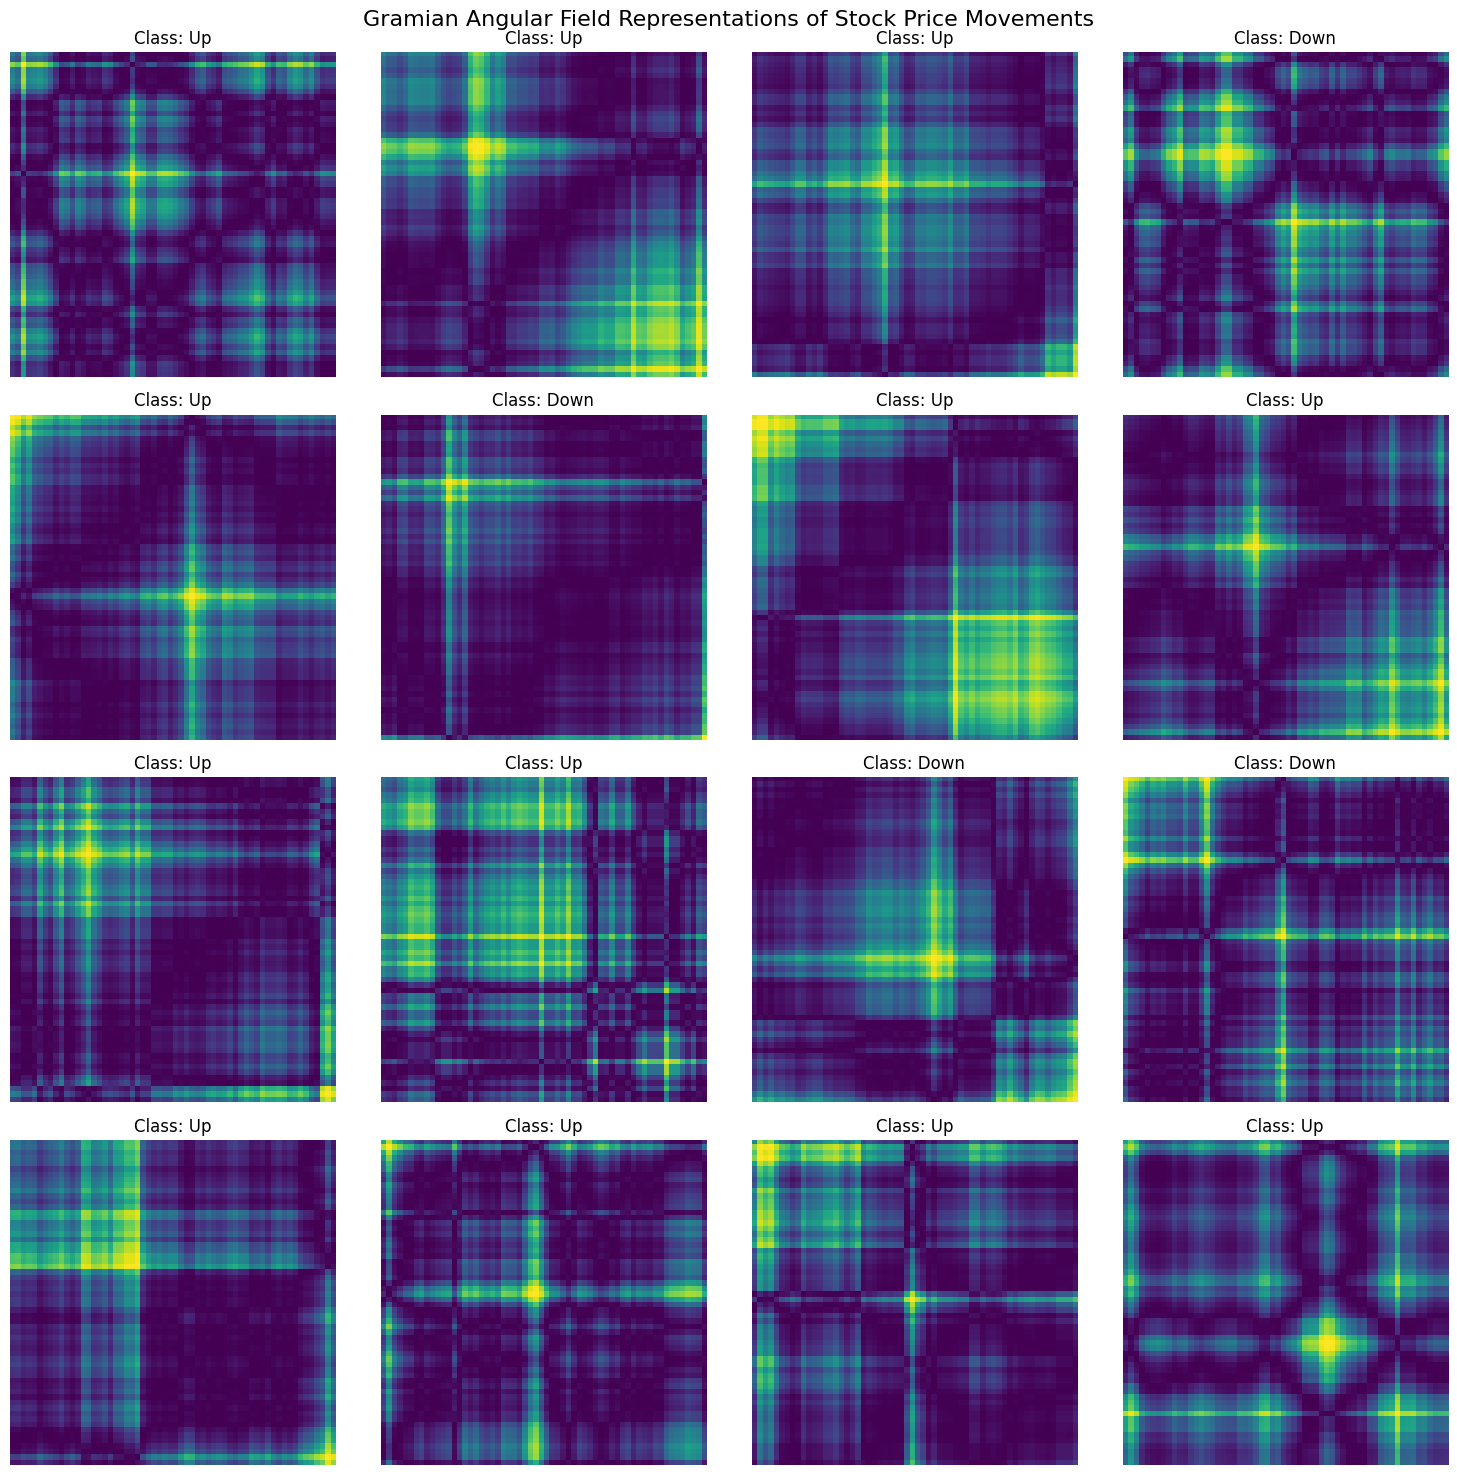

In [27]:
from fastai.vision.all import *
import torch
import matplotlib.pyplot as plt

class SafeResize(Transform):
    def __init__(self, size):
        self.size = size

    def encodes(self, x:TensorImage):
        if x.dim() == 3:
            x = x.unsqueeze(0)
            return TensorImage(F.interpolate(x, size=self.size, mode='bilinear', align_corners=False).squeeze(0))
        return x

def show_batch(dl, nrows=4, ncols=4):
    batch = dl.one_batch()
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        if i < len(batch[0]):
            img = batch[0][i].cpu().permute(1, 2, 0)[:,:,0]
            img = (img - img.min()) / (img.max() - img.min())
            ax.imshow(img, cmap='viridis')
            ax.axis('off')
            ax.set_title(f'Class: {"Up" if batch[1][i].item() == 1 else "Down"}')
    plt.suptitle("Gramian Angular Field Representations of Stock Price Movements", fontsize=16)
    plt.tight_layout()
    plt.show()

# Create DataBlock
dblock = DataBlock(blocks=(InMemoryImageBlock, CategoryBlock),
                   get_x=lambda i: images_list[i],
                   get_y=lambda i: str(image_df.iloc[i]['target']),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[SafeResize(size=(224,224))],
                   batch_tfms=aug_transforms())

# Create DataLoaders
dls = dblock.dataloaders(range(len(image_df)), bs=32, device='cuda' if torch.cuda.is_available() else 'cpu')

print(f"Train dataset size: {len(dls.train_ds)}")
print(f"Validation dataset size: {len(dls.valid_ds)}")

# Examine a batch
batch = dls.one_batch()
print(f"Shape of x in batch: {batch[0].shape}")
print(f"Shape of y in batch: {batch[1].shape}")
print(f"Min value in batch: {batch[0].min().item():.4f}")
print(f"Max value in batch: {batch[0].max().item():.4f}")

# Show a batch
show_batch(dls.train)

GPU available: True
GPU name: Tesla T4


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.722436,0.720230,0.500000,0.500000,00:01
1,0.692503,0.714290,0.487805,0.512195,00:01
2,0.648480,0.729167,0.542683,0.457317,00:01
3,0.596434,0.758408,0.542683,0.457317,00:01
4,0.539529,0.745512,0.500000,0.500000,00:02


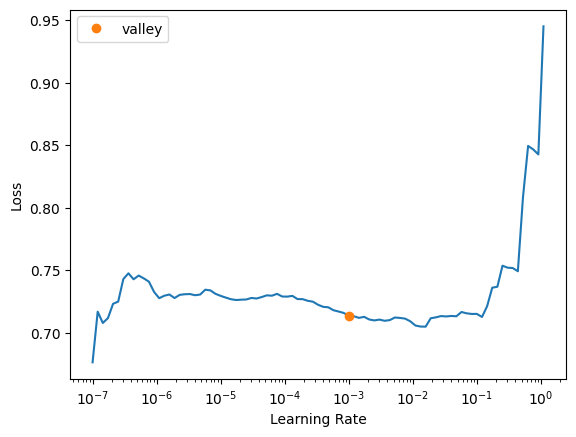

In [28]:
import torch
from fastai.vision.all import *
import timm

print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

def get_pretrained_model():
    return timm.create_model('resnet34', pretrained=True, num_classes=2)

# Assuming you have already defined and created your dblock and image_df
dls = dblock.dataloaders(range(len(image_df)), bs=32, device='cuda' if torch.cuda.is_available() else 'cpu')

# Create the model
model = get_pretrained_model()

# Move the model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()

# Create a custom learner
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy, error_rate])

# Find a good learning rate
learn.lr_find()

# Train the model
learn.fit_one_cycle(5, 1e-3)

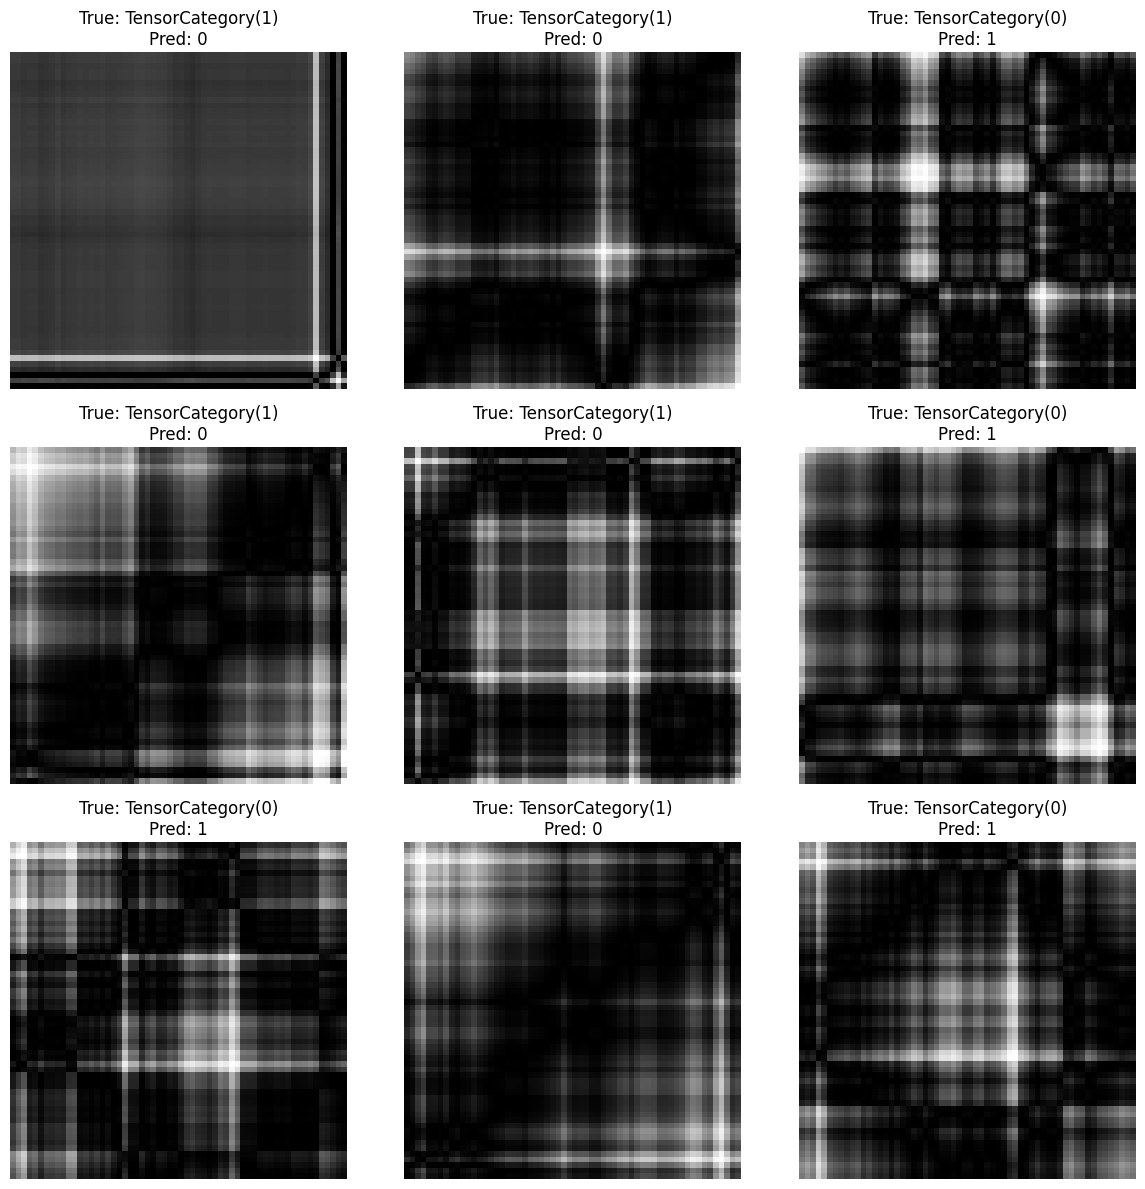

Number of true labels: 164
Number of predictions: 164


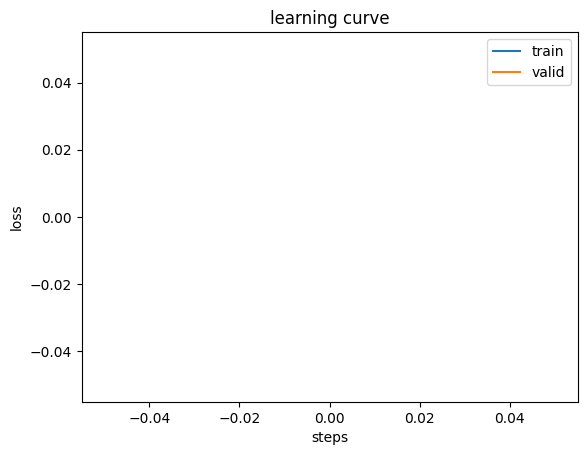

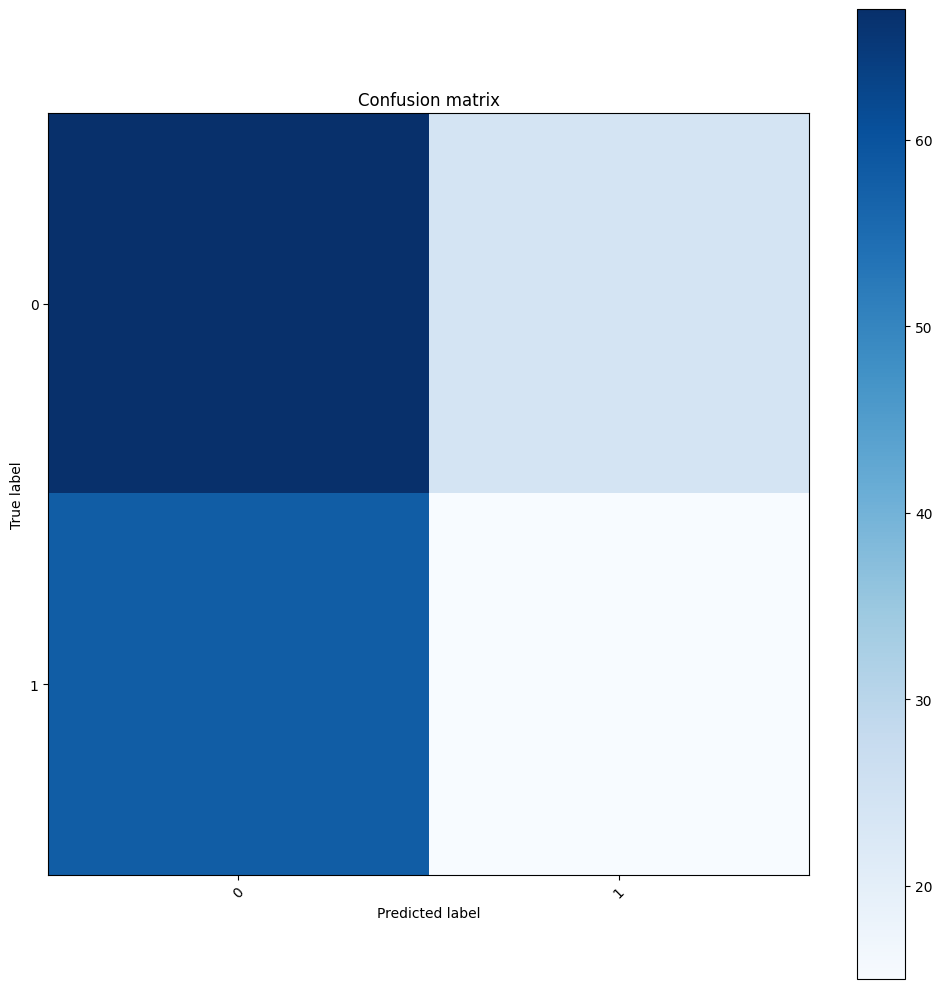

              precision    recall  f1-score   support

           0       0.54      0.74      0.62        91
           1       0.38      0.21      0.27        73

    accuracy                           0.50       164
   macro avg       0.46      0.47      0.44       164
weighted avg       0.47      0.50      0.46       164



In [29]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def show_results(learn, rows=3, cols=3):
    interp = ClassificationInterpretation.from_learner(learn)
    losses, idxs = interp.top_losses(rows*cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    for i, ax in enumerate(axes.flat):
        if i < len(idxs):
            img, label = learn.dls.valid_ds[idxs[i]]
            img_display = img.permute(1, 2, 0)[:,:,0]
            ax.imshow(img_display, cmap='gray')

            img_pred = img.unsqueeze(0)

            with torch.no_grad():
                output = learn.model(img_pred.to(learn.dls.device))
                pred_class = output.argmax().item()

            ax.set_title(f'True: {label}\nPred: {pred_class}')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Use this function instead of learn.show_results()
show_results(learn)

# Plot the learning rate vs. loss
learn.recorder.plot_loss()

def get_predictions(learn):
    learn.model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for batch in learn.dls.valid:
            inputs, target = batch
            outputs = learn.model(inputs)
            preds.append(outputs.argmax(dim=1))
            targets.append(target)
    return torch.cat(preds), torch.cat(targets)

def plot_confusion_matrix(learn):
    y_pred, y_true = get_predictions(learn)
    print(f"Number of true labels: {len(y_true)}")
    print(f"Number of predictions: {len(y_pred)}")
    cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    classes = learn.dls.vocab if hasattr(learn.dls, 'vocab') else range(cm.shape[0])
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Try to plot the confusion matrix
try:
    plot_confusion_matrix(learn)
except Exception as e:
    print(f"Error plotting confusion matrix: {str(e)}")

# Try to print the classification report
try:
    y_pred, y_true = get_predictions(learn)
    print(classification_report(y_true.cpu(), y_pred.cpu()))
except Exception as e:
    print(f"Error generating classification report: {str(e)}")

In [30]:
# import pickle

# # Save a variable (e.g., a trained model)
with open('/content/drive/My Drive/Stonks Predictor/model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
# # restore later
# with open('/content/drive/My Drive/Stonks Predictor/model.pkl', 'rb') as file:
#     model = pickle.load(file)